In [1]:
import polars as pl
import numpy as np
from typing import List


def kalman_filter_series(
        series: pl.Series,
        R: float = 0.01,  # 观测噪声协方差（越小越信）
        Q: float = 1e-5  # 过程噪声协方差（越小越稳）
) -> pl.Series:
    z = series.to_numpy()
    n = len(z)
    x_hat = np.zeros(n)  # 估计值
    P = np.zeros(n)  # 估计误差协方差
    x_hat[0] = z[0]
    P[0] = 1.0

    for k in range(1, n):
        # 预测更新
        x_hat_minus = x_hat[k - 1]
        P_minus = P[k - 1] + Q

        # 观测更新
        K = P_minus / (P_minus + R)  # 卡尔曼增益
        x_hat[k] = x_hat_minus + K * (z[k] - x_hat_minus)
        P[k] = (1 - K) * P_minus

    return pl.Series(name=f"{series.name}_kalman", values=x_hat)


# 判断序列是收敛、发散还是混沌系统：
def lyapunov_series(s: pl.Series, window: int) -> pl.Series:
    values = s.to_numpy()
    out = [None] * len(values)
    for i in range(window - 1, len(values)):
        x = values[i - window + 1:i + 1]
        lyap = np.mean(np.log(np.abs(np.diff(x)) + 1e-8))
        out[i] = lyap
    return pl.Series(name=f"{s.name}_lyap_{window}", values=out)


def fft_power_topk_series(series: pl.Series, window: int = 64, k: int = 3) -> pl.Series:
    values = series.to_list()
    out = []

    for i in range(len(values)):
        if i < window - 1:
            out.append(None)
        else:
            window_data = values[i - window + 1: i + 1]
            fft = np.fft.fft(window_data)
            powers = np.abs(fft[: window // 2])
            out.append(np.sum(np.sort(powers)[-k:]))

    return pl.Series(f"{series.name}_fft_power_top{k}", out)


def batch_apply_single_series(
        df_single_series_cal: pl.DataFrame,
        window: int,
        cols: List[str] = None
) -> List[pl.Series]:
    single_series = []
    # single features transformation
    for col in cols:
        df_col_series = df_single_series_cal[col]
        single_series.extend([
            kalman_filter_series(df_col_series),
            lyapunov_series(df_col_series, window),
            fft_power_topk_series(df_col_series, window),
        ])

    return single_series


def squared_expr(col: str) -> pl.Expr:
    return (pl.col(col) ** 2).alias(f"{col}_squared")


def rolling_volatility_expr(col: str, window: int) -> pl.Expr:
    return pl.col(col).rolling_std(window).alias(f"{col}_volatility_{window}")


def rolling_skew_expr(col: str, window: int) -> pl.Expr:
    mean = pl.col(col).rolling_mean(window)
    std = pl.col(col).rolling_std(window) + 1e-8
    m3 = ((pl.col(col) - mean) ** 3).rolling_mean(window)
    return (m3 / (std ** 3)).alias(f"{col}_skew")


def rolling_kurt_expr(col: str, window: int) -> pl.Expr:
    mean = pl.col(col).rolling_mean(window)
    std = pl.col(col).rolling_std(window) + 1e-8
    m4 = ((pl.col(col) - mean) ** 4).rolling_mean(window)
    return (m4 / (std ** 4)).alias(f"{col}_kurt")


def diff_expr(col: str, lag: int = 1) -> pl.Expr:
    return (pl.col(col) - pl.col(col).shift(lag)).alias(f"{col}_diff_{lag}")


def second_order_diff_expr(col: str, lag: int = 1) -> pl.Expr:
    # 二阶差分 = 一阶差分的差分
    first_diff = pl.col(col) - pl.col(col).shift(lag)
    second_diff = first_diff - first_diff.shift(lag)
    return second_diff.alias(f"{col}_second_order_diff_{lag}")


def momentum_ratio_expr(col: str, lag: int = 200) -> pl.Expr:
    # 动量比率 = x_t / x_{t-lag}
    return (pl.col(col) / (pl.col(col).shift(lag) + 1e-8)).alias(f"{col}_momentum_ratio_{lag}")


def lag_expr(col: str, lag: int = 200) -> pl.Expr:
    return pl.col(col).shift(lag).alias(f"{col}_lag_{lag}")


def inverse_expr(col: str) -> pl.Expr:
    return (1 / (pl.col(col) + 1e-8)).alias(f"{col}_inverse")


def abs_expr(col: str) -> pl.Expr:
    return pl.col(col).abs().alias(f"{col}_abs")


def cross_product_expr(a: str, b: str) -> pl.Expr:
    return (pl.col(a) * pl.col(b)).alias(f"{a}_X_{b}")


def cross_div_expr(a: str, b: str) -> pl.Expr:
    return (pl.col(a) / (pl.col(b) + 1e-8)).alias(f"{a}_DIV_{b}")


def spread_product_expr(a: str, b: str) -> pl.Expr:
    col_a = pl.col(a)
    col_b = pl.col(b)
    max_col = pl.when(col_a >= col_b).then(col_a).otherwise(col_b)
    min_col = pl.when(col_a < col_b).then(col_a).otherwise(col_b)
    return ((max_col - min_col) * (col_a + col_b)).alias(f"{a}_SPREAD_X_MAG_{b}")


def conditioned_cross_expr_rolling(a: str, b: str, window: int) -> pl.Expr:
    mean_col = pl.col(a).rolling_mean(window)
    std_col = pl.col(a).rolling_std(window)
    upper = mean_col + std_col
    lower = mean_col - std_col

    return (
        pl.when((pl.col(a) > upper) | (pl.col(a) < lower))
        .then(pl.col(a) * pl.col(b))
        .otherwise(0.0)
        .alias(f"{a}_X_{b}_cond_dev_rolling{window}")
    )


def cols_to_transforms(
        df: pl.DataFrame,
        exclude_cols: List[str] = None
) -> List[str]:
    if exclude_cols is None:
        exclude_cols = ['timestamp', 'timestamp_dt', 'symbol']

    if isinstance(df, pl.LazyFrame):
        cols = df.collect_schema().names()
    else:
        cols = df.columns

    cols = [
        col for col in cols
        if col not in exclude_cols 
        and col.startswith("z_")
        and not (
            col.endswith('_rolling_mean') or
            col.endswith('_rolling_std') or
            col.endswith('_scaled')
        )
    ]

    return cols


def batch_apply_single_exprs(
        window: int,
        lag: int,
        cols: List[str] = None
) -> List[str]:
    single_exprs = []
    # single features transformation
    for col in cols:
        single_exprs.extend([
            squared_expr(col),
            rolling_volatility_expr(col, window),
            rolling_skew_expr(col, window),
            rolling_kurt_expr(col, window),
            diff_expr(col, lag),
            second_order_diff_expr(col, lag),
            momentum_ratio_expr(col, lag),
            lag_expr(col, lag),
            inverse_expr(col),
            abs_expr(col),
        ])

    return single_exprs


def batch_apply_multi_exprs(
        window: int,
        cols: List[str] = None
) -> List[str]:
    multi_exprs = []

    n = len(cols)
    for i in range(n):
        for j in range(i + 1, n):
            a, b = cols[i], cols[j]
            multi_exprs.extend([
                cross_product_expr(a, b),
                cross_div_expr(a, b),
                spread_product_expr(a, b, ),
                conditioned_cross_expr_rolling(a, b, window),
            ])

    return multi_exprs

def batch_apply_transforms(
        df_to_transforms: pl.DataFrame,
        window: int,
        lag: int,
        exclude_cols: List[str] = None
) -> pl.DataFrame:
    base_cols = cols_to_transforms(df_to_transforms, exclude_cols)
    series = batch_apply_single_series(df_to_transforms, window, base_cols)

    for i, s in enumerate(series):
        series[i] = s.fill_nan(0.0).fill_null(strategy="forward")

    df_to_transforms = df_to_transforms.with_columns(series)

    single_exprs = batch_apply_single_exprs(window, lag, base_cols)
    multi_exprs = batch_apply_multi_exprs(window, base_cols)

    exprs = single_exprs + multi_exprs
    return df_to_transforms.with_columns(exprs)


In [2]:
from tqdm import tqdm

def split_df_by_month(
        df: pl.DataFrame,
        ts_col: str = "timestamp"
) -> List[pl.DataFrame]:
    df = df.with_columns([
        pl.col(ts_col).cast(pl.Datetime).alias(f"{ts_col}_dt")
    ])

    df = df.with_columns([
        pl.col(f"{ts_col}_dt").dt.truncate("1mo").alias("month_start")
    ])

    unique_months = df.select("month_start").unique().sort("month_start")

    monthly_dfs = [
        df.filter(pl.col("month_start") == mo).drop("month_start")
        for mo in unique_months["month_start"]
    ]

    return monthly_dfs


def clean_df_drop_nulls(
        df_to_clean: pl.DataFrame,
        null_threshold: int = 10000,
        verbose: bool = True
) -> pl.DataFrame:
    pd_df = df_to_clean.to_pandas()

    null_counts = pd_df.isnull().sum()
    cols_to_drop = null_counts[null_counts > null_threshold].index

    pd_df_cleaned = pd_df.drop(columns=cols_to_drop)
    pd_df_clean = pd_df_cleaned.dropna()
    pl_df_clean = pl.from_pandas(pd_df_clean)

    if verbose:
        max_null_col = null_counts.idxmax()
        max_null_count = null_counts.max()
        print("各列空值数量：")
        print(null_counts[null_counts > 0])
        print(f"删除空值超过 {null_threshold} 的列：{list(cols_to_drop)}")
        print(f"删除列后，DataFrame形状：{pd_df_cleaned.shape}")
        print(f"空值最多的列是：{max_null_col}，共有 {max_null_count} 个空值")
        print(f"删除空值行后，DataFrame形状：{pd_df_clean.shape}")

    return pl_df_clean

def avg_steps_to_volatility(prices: np.ndarray, target_ratio: float) -> int:
    n = len(prices)
    steps_list = []
    for i in tqdm(range(n), desc=f"cal abs change {target_ratio*100:.2f}% avg steps"):
        start_price = prices[i]
        steps = -1
        for j in range(i + 1, n):
            change = abs(prices[j] / start_price - 1)
            if change >= target_ratio:
                steps = j - i
                break
        if steps != -1:
            steps_list.append(steps)
    if len(steps_list) == 0:
        return -1
    return int(np.mean(steps_list))

def future_return_expr(price_col: str, step: int) -> pl.Expr:
    return ((pl.col(price_col).shift(-step) - pl.col(price_col)) / pl.col(price_col)).alias(f"future_return_{step}")

def rolling_minmax_scaled_expr(
        col: str,
        min_col: str,
        max_col: str,
        scaled_col: str
) -> pl.Expr:
    return (
        ((pl.col(col) - pl.col(min_col)) / (pl.col(max_col) - pl.col(min_col) + 1e-9))
        .clip(0.0, 1.0)
        .fill_null(0.5)
        .alias(scaled_col)
    )

def rolling_minmax_normalize(rollin_df: pl.DataFrame, window: int) -> pl.DataFrame:
    columns_to_normalize = [
        col for col in rollin_df.columns
        if col not in ['px', 'timestamp', 'timestamp_dt', 'symbol']
           and not col.startswith("future_return_")
           and not col.endswith('_scaled')  # scaled 是最终产物，保留
           and not (
                col.endswith('_rolling_mean') or
                col.endswith('_rolling_std') or
                col.endswith('_rolling_max') or
                col.endswith('_rolling_min')
        )
    ]

    rolling_cols = []
    for column in columns_to_normalize:
        rolling_cols.extend([
            pl.col(column).rolling_max(window, min_samples=1).alias(f"{column}_rolling_max"),
            pl.col(column).rolling_min(window, min_samples=1).alias(f"{column}_rolling_min"),
        ])

    intermediate_cols = [
                            f"{column}_rolling_max" for column in columns_to_normalize
                        ] + [
                            f"{column}_rolling_min" for column in columns_to_normalize
                        ]

    return (
        rollin_df
        .with_columns(rolling_cols)
        .with_columns([
            rolling_minmax_scaled_expr(
                col=column,
                min_col=f"{column}_rolling_min",
                max_col=f"{column}_rolling_max",
                scaled_col=f"{column}_scaled"
            ) for column in columns_to_normalize
        ])
        .drop(intermediate_cols)
    )

def rolling_mean_tanh_scaled_expr(
        col: str,
        scaled_col: str,
        window: int
) -> pl.Expr:
    return (
        pl.col(col)
        .rolling_mean(window, min_samples=1)
        .tanh()
        .alias(scaled_col)
    )

def rolling_mean_tanh_normalize(rollin_df: pl.DataFrame, window: int) -> pl.DataFrame:
    columns_to_normalize = [
        col for col in rollin_df.columns
        if col not in ['px', 'timestamp', 'timestamp_dt', 'symbol']
           and not col.startswith("future_return_")
           and not col.endswith('_scaled')
    ]

    return rollin_df.with_columns([
        rolling_mean_tanh_scaled_expr(
            col=column,
            scaled_col=f"{column}_scaled",
            window=window
        ) for column in columns_to_normalize
    ])

def rolling_ic_ir_icto_index(
        df: pl.DataFrame,
        target_col: str,
        exclude_prefixes: list[str],
        window_size: int,
        step: int = 1,
) -> pl.DataFrame:
    # feature_cols = [
    #     col for col in df.columns
    #     if col.endswith("_scaled") 
    #         and all(not col.startswith(prefix) for prefix in exclude_prefixes)
    #         and not col.startswith("future_return_")
    #         and col != "px"
    # ]
    feature_cols = [
        col for col in df.columns
        if col.endswith("_scaled") 
            and col.startswith("z_") 
            and all(not col.startswith(prefix) for prefix in exclude_prefixes)
            and not col.startswith("future_return_")
            and col != "px"
    ]

    n = df.height
    results = []
    prev_ranks = {}

    for start in tqdm(range(0, n - window_size + 1, step), desc="Rolling IC & ICTO"):
        end = start + window_size
        df_win = df.slice(start, window_size)

        # rank 转换
        df_ranked = df_win.with_columns([
            (pl.col(c).rank(method="average") / window_size).alias(c + "_rank") for c in feature_cols + [target_col]
        ])
        target_rank_col = target_col + "_rank"

        for feat in feature_cols:
            feat_rank_col = feat + "_rank"
            ic = df_ranked.select(
                pl.corr(pl.col(feat_rank_col), pl.col(target_rank_col)).alias("ic")
            ).to_series()[0]

            turnover = None
            if feat in prev_ranks:
                cur_ranks = df_ranked[feat_rank_col].to_numpy()
                prev = prev_ranks[feat]
                if len(prev) == len(cur_ranks):
                    turnover = np.mean(np.abs(cur_ranks - prev))

            # 更新 prev_ranks
            prev_ranks[feat] = df_ranked[feat_rank_col].to_numpy()

            results.append({
                "window_start": int(start),
                "window_end": int(end - 1),
                "factor": str(feat),
                "ic": float(ic) if not np.isnan(ic) else None,
                "turnover": float(turnover) if turnover is not None else None
            })

    df_result = pl.DataFrame(
        results,
        schema={
            "window_start": pl.Int64,
            "window_end": pl.Int64,
            "factor": pl.Utf8,
            "ic": pl.Float64,
            "turnover": pl.Float64,
        }
    )      
    return (
        df_result
        .group_by("factor")
        .agg([
            pl.mean("ic").alias("mean_ic"),
            pl.std("ic").alias("std_ic"),
            pl.mean("turnover").alias("mean_turnover")
        ])
        .with_columns([
            (pl.col("mean_ic") / pl.col("std_ic")).alias("ir"),
            (pl.col("mean_ic") / (pl.col("mean_turnover") + 1e-8)).abs().alias("icto")
        ])
        .sort("icto", descending=True)
    )

In [3]:
origin_df = pl.read_csv("C:/quant/data/binance_resampled_data/ETHUSDT_factors_threshold0.001_rolling2000.csv")
monthly_dataframes = split_df_by_month(origin_df)


In [4]:
# mo_df = batch_apply_transforms(origin_df, 2000, 1)
# mo_df = batch_apply_transforms(origin_df, 500, 1)

mo_df = origin_df
print(f"Polars DataFrame size: {mo_df.estimated_size() / (1024 ** 2):.4f} MB")

prices_np = mo_df["px"].to_numpy()
avg_steps_05pct = avg_steps_to_volatility(prices_np, 0.005)
avg_steps_1pct = avg_steps_to_volatility(prices_np, 0.01)
avg_steps_2pct = avg_steps_to_volatility(prices_np, 0.02) 
avg_steps_5pct = avg_steps_to_volatility(prices_np, 0.05) 

print("波动 ±0.5% 的均值步数:", avg_steps_05pct)
print("波动 ±1% 的均值步数:", avg_steps_1pct)
print("波动 ±2% 的均值步数:", avg_steps_2pct)
print("波动 ±5% 的均值步数:", avg_steps_5pct)

# cal future ret
mo_df = mo_df.with_columns([
    future_return_expr("px", avg_steps_05pct),
    future_return_expr("px", avg_steps_1pct),
    future_return_expr("px", avg_steps_2pct),
    future_return_expr("px", avg_steps_5pct),

])
print(mo_df)

mo_df = rolling_mean_tanh_normalize(mo_df, 50)

mo_df = clean_df_drop_nulls(mo_df)



Polars DataFrame size: 61.1661 MB


cal abs change 5.00% avg steps: 100%|█████████████████████████████████████████████████████████████████████| 85289/85289 [00:34<00:00, 2486.75it/s]


波动 ±0.5% 的均值步数: 27
波动 ±1% 的均值步数: 91
波动 ±2% 的均值步数: 347
波动 ±5% 的均值步数: 2233
shape: (85_289, 98)
┌──────────────────┬─────────┬────────────┬─────────────┬───┬──────────────────┬──────────────────┬───────────────────┬────────────────────┐
│ timestamp        ┆ px      ┆ sum_buy_sz ┆ sum_sell_sz ┆ … ┆ future_return_27 ┆ future_return_91 ┆ future_return_347 ┆ future_return_2233 │
│ ---              ┆ ---     ┆ ---        ┆ ---         ┆   ┆ ---              ┆ ---              ┆ ---               ┆ ---                │
│ i64              ┆ f64     ┆ f64        ┆ f64         ┆   ┆ f64              ┆ f64              ┆ f64               ┆ f64                │
╞══════════════════╪═════════╪════════════╪═════════════╪═══╪══════════════════╪══════════════════╪═══════════════════╪════════════════════╡
│ 1743998074066000 ┆ 1540.41 ┆ 1021.0     ┆ 1086.683    ┆ … ┆ 0.003382         ┆ 0.005771         ┆ -0.002168         ┆ -0.023487          │
│ 1743998097256000 ┆ 1542.02 ┆ 1203.548   ┆ 822.216     ┆ … ┆

In [5]:
exclude_prefixes = ['px', 'timestamp', 'timestamp_dt', 'symbol']
target_col = f"future_return_{avg_steps_2pct}"

In [6]:
ic_df = rolling_ic_ir_icto_index(
    mo_df,
    target_col=target_col,
    exclude_prefixes=exclude_prefixes,
    window_size=10000,
    step=100,  # 滑窗步长
)
print(ic_df)

Rolling IC & ICTO: 100%|███████████████████████████████████████████████████████████████████████████████████████| 731/731 [00:03<00:00, 196.53it/s]

shape: (36, 6)
┌─────────────────────────────────┬───────────┬──────────┬───────────────┬───────────┬──────────┐
│ factor                          ┆ mean_ic   ┆ std_ic   ┆ mean_turnover ┆ ir        ┆ icto     │
│ ---                             ┆ ---       ┆ ---      ┆ ---           ┆ ---       ┆ ---      │
│ str                             ┆ f64       ┆ f64      ┆ f64           ┆ f64       ┆ f64      │
╞═════════════════════════════════╪═══════════╪══════════╪═══════════════╪═══════════╪══════════╡
│ z_ts_velo_rol_mean_2000_scaled  ┆ 0.147733  ┆ 0.179304 ┆ 0.064998      ┆ 0.823926  ┆ 2.272873 │
│ z_sum_sz_rol_mean_2000_scaled   ┆ -0.143142 ┆ 0.175638 ┆ 0.066215      ┆ -0.814985 ┆ 2.16179  │
│ z_oi_down_divergence_scaled     ┆ 0.119332  ┆ 0.106302 ┆ 0.113196      ┆ 1.122571  ┆ 1.05421  │
│ z_bs_ratio_rol_mean_2000_scale… ┆ 0.085724  ┆ 0.171491 ┆ 0.087509      ┆ 0.499872  ┆ 0.979596 │
│ z_px_pct_rol_sum_2000_scaled    ┆ 0.077866  ┆ 0.160805 ┆ 0.096563      ┆ 0.484225  ┆ 0.806369 │
│ …  

In [7]:
adf = ic_df.to_pandas().dropna()
adf


,factor,mean_ic,std_ic,mean_turnover,ir,icto
0,z_ts_velo_rol_mean_2000_scaled,0.147733,0.179304,0.064998,0.823926,2.272873
1,z_sum_sz_rol_mean_2000_scaled,-0.143142,0.175638,0.066215,-0.814985,2.161790
2,z_oi_down_divergence_scaled,0.119332,0.106302,0.113196,1.122571,1.054210
3,z_bs_ratio_rol_mean_2000_scaled,0.085724,0.171491,0.087509,0.499872,0.979596
4,z_px_pct_rol_sum_2000_scaled,0.077866,0.160805,0.096563,0.484225,0.806369
5,z_bs_imba_rol_mean_2000_scaled,0.083300,0.183947,0.104440,0.452849,0.797592
6,z_px_velo_rol_mean_2000_scaled,-0.076898,0.161071,0.096693,-0.477415,0.795276
7,z_factor_px_oi_force_scaled,0.087227,0.112373,0.128303,0.776226,0.679851
8,z_sum_sz_px_pct_rol_sum_2000_scaled,0.064263,0.162485,0.099366,0.395499,0.646728
9,z_factor_momentum_trend_confirm_scaled,0.114805,0.122784,0.214218,0.935017,0.535926


In [8]:
selected_factors = adf["factor"].to_list()
print(selected_factors[:20])

['z_ts_velo_rol_mean_2000_scaled', 'z_sum_sz_rol_mean_2000_scaled', 'z_oi_down_divergence_scaled', 'z_bs_ratio_rol_mean_2000_scaled', 'z_px_pct_rol_sum_2000_scaled', 'z_bs_imba_rol_mean_2000_scaled', 'z_px_velo_rol_mean_2000_scaled', 'z_factor_px_oi_force_scaled', 'z_sum_sz_px_pct_rol_sum_2000_scaled', 'z_factor_momentum_trend_confirm_scaled', 'z_factor_long_term_oi_trend_scaled', 'z_lob_ratio_rol_mean_2000_scaled', 'z_factor_oi_px_divergence_with_sign_scaled', 'z_bid_px_gap_rol_mean_2000_scaled', 'z_oi_px_diff2000_scaled', 'z_oi_di_scaled', 'z_factor_sentiment_net_scaled', 'z_ask_px_gap_rol_mean_2000_scaled', 'z_oi_up_divergence_scaled', 'z_factor_oi_momentum_punch_scaled']


In [9]:
from sklearn.feature_selection import mutual_info_regression

def filter_by_mutual_info(df: pl.DataFrame, factor_cols: list[str], target_col: str, top_k: int = 50) -> list[str]:
    X = np.column_stack([df[col].to_numpy() for col in factor_cols])
    y = df[target_col].to_numpy()

    mi_scores = mutual_info_regression(X, y, discrete_features=False)
    sorted_idx = np.argsort(mi_scores)[::-1]
    selected = [factor_cols[i] for i in sorted_idx[:top_k]]

    return selected

# final_selected_factors = filter_by_mutual_info(mo_df, selected_cols, target_col=target_col, top_k=30)
# print(final_selected_factors)

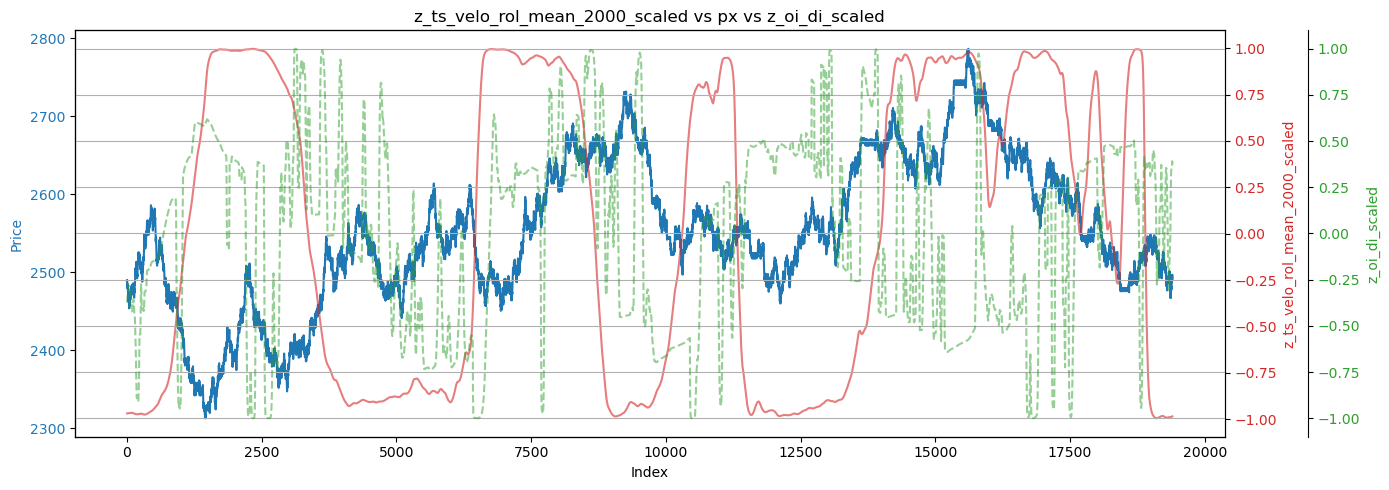

In [10]:
import polars as pl
import matplotlib.pyplot as plt

def plot_factor_price_target(
    df: pl.DataFrame,
    factor_name: str,
    price_col: str,
    target_col: str,
    n: int = 300
):
    df_plot = df.select([price_col, factor_name, target_col]).tail(n).to_pandas()

    fig, ax1 = plt.subplots(figsize=(14, 5))

    ax1.set_xlabel("Index")
    ax1.set_ylabel("Price", color="tab:blue")
    ax1.plot(df_plot[price_col], color="tab:blue", label="Price")
    ax1.tick_params(axis="y", labelcolor="tab:blue")

    ax2 = ax1.twinx()
    ax2.set_ylabel(factor_name, color="tab:red")
    ax2.plot(df_plot[factor_name], color="tab:red", alpha=0.6, label=factor_name)
    ax2.tick_params(axis="y", labelcolor="tab:red")

    ax3 = ax1.twinx()
    ax3.spines.right.set_position(("outward", 60))  # 第三个y轴往右偏移
    ax3.set_ylabel(target_col, color="tab:green")
    ax3.plot(df_plot[target_col], color="tab:green", alpha=0.5, linestyle="--", label=target_col)
    ax3.tick_params(axis="y", labelcolor="tab:green")

    plt.title(f"{factor_name} vs {price_col} vs {target_col}")
    fig.tight_layout()
    plt.grid(True)
    plt.show()

plot_factor_price_target(
    df=mo_df.with_columns([
        (pl.col("z_factor_impact_momentum") + pl.col("z_factor_oi_trend_slope")).rolling_mean(300).tanh()
        .alias("pread")
    ]),
    factor_name="z_ts_velo_rol_mean_2000_scaled",
    price_col="px",
    target_col="z_oi_di_scaled",  # 也可以改成别的 target，比如方向标签
    n=19400
)


In [11]:
import polars as pl
import pandas as pd

def time_split(
    df: pl.DataFrame,
    feature_cols: list[str],
    target_col: str,
    split_ratio: float = 0.7
):
    # 排序并去除缺失
    df = df.sort('timestamp').drop_nulls(subset=feature_cols + [target_col]).to_pandas()

    n = df.shape[0]
    split_point = int(n * split_ratio)

    df_train = df.iloc[:split_point]
    df_test = df.iloc[split_point:]

    X_train = df_train[feature_cols]  # 保留为 pandas DataFrame（带列名）
    y_train = df_train[target_col]

    X_test = df_test[feature_cols]
    y_test = df_test[target_col]

    return X_train, y_train, X_test, y_test


In [12]:
exclude_prefixes = ['px', 'timestamp', 'timestamp_dt', 'symbol']
target_col = f"future_return_{avg_steps_2pct}"

In [13]:
X_train, y_train, X_test, y_test = time_split(mo_df, selected_factors, target_col)
print(y_test)

58139   -0.017414
58140   -0.017252
58141   -0.017113
58142   -0.019219
58143   -0.019169
           ...   
83051    0.000008
83052   -0.000048
83053   -0.000068
83054    0.002020
83055    0.002059
Name: future_return_347, Length: 24917, dtype: float64


In [14]:
from sklearn.mixture import GaussianMixture
import numpy as np

y_train_np = y_train.to_numpy()
y_test_np = y_test.to_numpy()

# GMM 拟合 y_train（未来收益率）
gmm = GaussianMixture(n_components=2, random_state=42)
gmm.fit(y_train_np.reshape(-1, 1))  # GMM 需要二维输入

# 聚类成两个标签
cluster_labels = gmm.predict(y_train_np.reshape(-1, 1))

# 均值大的聚类 → 上涨标签
means = gmm.means_.flatten()
up_cluster = np.argmax(means)
y_train_binary = (cluster_labels == up_cluster).astype(int)

# 对测试集做同样的聚类预测 → 注意不 fit
test_cluster_labels = gmm.predict(y_test_np.reshape(-1, 1))
y_test_binary = (test_cluster_labels == up_cluster).astype(int)


GMM 均值: [-0.00914479  0.01664555]
上涨类的编号: 1
训练集中上涨的比例: 0.4838576514903937
测试集中上涨的比例: 0.41413492796082996
📈 Train Skew: 0.051485047119091014
📈 Test Skew: 0.08236955186327488
🔺 Train Kurtosis: 2.817788906062943
🔺 Test Kurtosis: 2.472219529167757


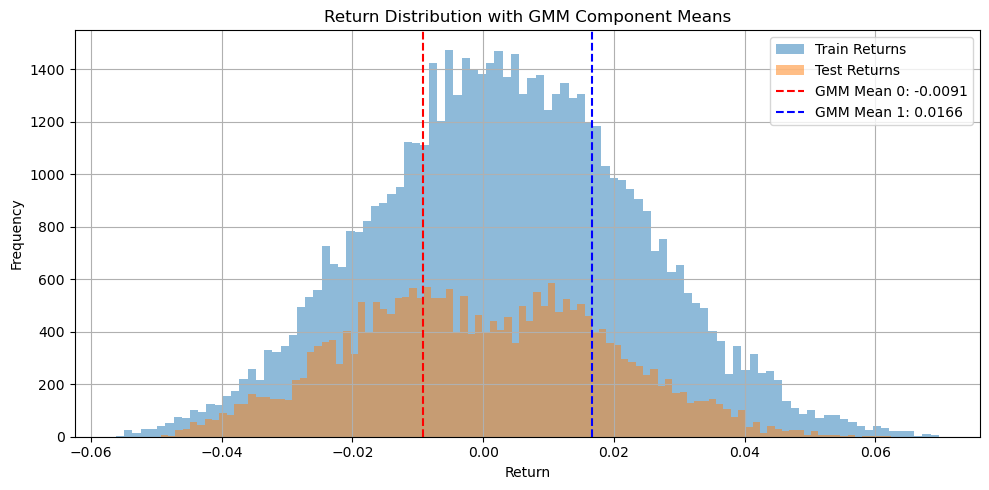

In [15]:
print("GMM 均值:", means)
print("上涨类的编号:", up_cluster)
print("训练集中上涨的比例:", y_train_binary.mean())
print("测试集中上涨的比例:", y_test_binary.mean())

import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis

# 偏度：衡量分布的不对称性，0 = 对称；>0 = 右偏；<0 = 左偏
train_skew = skew(y_train_np)
test_skew = skew(y_test_np)

# 峰度：衡量尖峭程度，3 = 正态；>3 = 尖（肥尾）；<3 = 平
train_kurt = kurtosis(y_train_np, fisher=False)  # fisher=False 表示不减3，直接给出正态=3
test_kurt = kurtosis(y_test_np, fisher=False)

print("📈 Train Skew:", train_skew)
print("📈 Test Skew:", test_skew)
print("🔺 Train Kurtosis:", train_kurt)
print("🔺 Test Kurtosis:", test_kurt)

plt.figure(figsize=(10, 5))
plt.hist(y_train, bins=100, alpha=0.5, label='Train Returns')
plt.hist(y_test, bins=100, alpha=0.5, label='Test Returns')
plt.axvline(means[0], color='red', linestyle='--', label=f'GMM Mean 0: {means[0]:.4f}')
plt.axvline(means[1], color='blue', linestyle='--', label=f'GMM Mean 1: {means[1]:.4f}')
plt.title("Return Distribution with GMM Component Means")
plt.xlabel("Return")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [16]:
import matplotlib.pyplot as plt
import numpy as np

def plot_last_n_rows(y_test, y_test_binary, y_pred_prob, n=700):
    # 取最后 n 行数据
    y_test_slice = y_test[-n:]
    y_test_binary_slice = y_test_binary[-n:]
    y_pred_prob_slice = y_pred_prob[-n:]
    
    time_index = np.arange(len(y_test_slice))  # 从0开始索引长度n

    fig, ax1 = plt.subplots(figsize=(16, 7))

    # 原始连续收益，左侧y轴
    ax1.plot(time_index, y_test_slice, label="Original Future Returns", color='gray', alpha=0.8)
    ax1.set_ylabel("Original Future Returns", color='gray')
    ax1.tick_params(axis='y', labelcolor='gray')

    # 第2个y轴，显示GMM标签
    ax2 = ax1.twinx()
    ax2.scatter(time_index, y_test_binary_slice, label="GMM Labels", color='tab:blue', marker='o', s=20, alpha=0.7)
    ax2.set_ylabel("GMM Labels (0 or 1)", color='tab:blue')
    ax2.tick_params(axis='y', labelcolor='tab:blue')
    ax2.set_ylim(-0.1, 1.1)

    # 第3个y轴，再右偏移，显示LGBM预测概率
    ax3 = ax1.twinx()
    ax3.spines.right.set_position(("outward", 60))
    ax3.plot(time_index, y_pred_prob_slice, label="MODEL Predicted Probability", color='tab:green', alpha=0.4)
    ax3.set_ylabel("MODEL Predicted Probability", color='tab:green')
    ax3.tick_params(axis='y', labelcolor='tab:green')
    ax3.set_ylim(-0.05, 1.05)

    # x轴和标题
    ax1.set_xlabel("Time Index")
    plt.title(f"Compare Original Returns, GMM Labels & LGBM Prediction (Last {n} Rows)")

    # 合并图例
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    lines_3, labels_3 = ax3.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2 + lines_3, labels_1 + labels_2 + labels_3, loc='best')

    plt.show()



In [52]:
import lightgbm as lgb
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np


model = lgb.LGBMClassifier(n_estimators=5500, learning_rate=0.0005, max_depth=12, verbose=-1)
model.fit(X_train, y_train_binary)

# 预测测试集
y_pred_prob = model.predict_proba(X_test)[:, 1]
y_pred_label = (y_pred_prob >= 0.5).astype(int)

# 评估测试集
print("Test Accuracy:", accuracy_score(y_test_binary, y_pred_label))
print(classification_report(y_test_binary, y_pred_label))
cm = confusion_matrix(y_test_binary, y_pred_label)
print("Confusion Matrix:")
print(cm)

Test Accuracy: 0.5523136814223221
              precision    recall  f1-score   support

           0       0.63      0.57      0.60     14598
           1       0.46      0.53      0.49     10319

    accuracy                           0.55     24917
   macro avg       0.55      0.55      0.55     24917
weighted avg       0.56      0.55      0.56     24917

Confusion Matrix:
[[8297 6301]
 [4854 5465]]


In [53]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

# 设置上下概率阈值
lower_thresh = 0.1
upper_thresh = 0.9

# 初始化标签为 -1（表示不出手）
y_pred_label = np.full_like(y_pred_prob, fill_value=-1, dtype=int)

# 预测为下跌（做空）
y_pred_label[y_pred_prob <= lower_thresh] = 0

# 预测为上涨（做多）
y_pred_label[y_pred_prob >= upper_thresh] = 1

# 筛选出模型明确给出方向的样本
mask = y_pred_label != -1

# 评估：只看模型明确判断的那部分（即“出手”的预测）
print("✅ CatBoost Test Accuracy (Confident Predictions):", accuracy_score(y_test_binary[mask], y_pred_label[mask]))
print("📊 Classification Report (Confident Predictions):")
print(classification_report(y_test_binary[mask], y_pred_label[mask]))

print("🧮 Confusion Matrix (Confident Predictions):")
print(confusion_matrix(y_test_binary[mask], y_pred_label[mask]))

# 出手率（模型愿意下单的比例）
print("📈 Trading Rate (Confident Predictions):", mask.mean())


✅ CatBoost Test Accuracy (Confident Predictions): 0.9318600368324125
📊 Classification Report (Confident Predictions):
              precision    recall  f1-score   support

           0       1.00      0.66      0.80       109
           1       0.92      1.00      0.96       434

    accuracy                           0.93       543
   macro avg       0.96      0.83      0.88       543
weighted avg       0.94      0.93      0.93       543

🧮 Confusion Matrix (Confident Predictions):
[[ 72  37]
 [  0 434]]
📈 Trading Rate (Confident Predictions): 0.0217923506040053


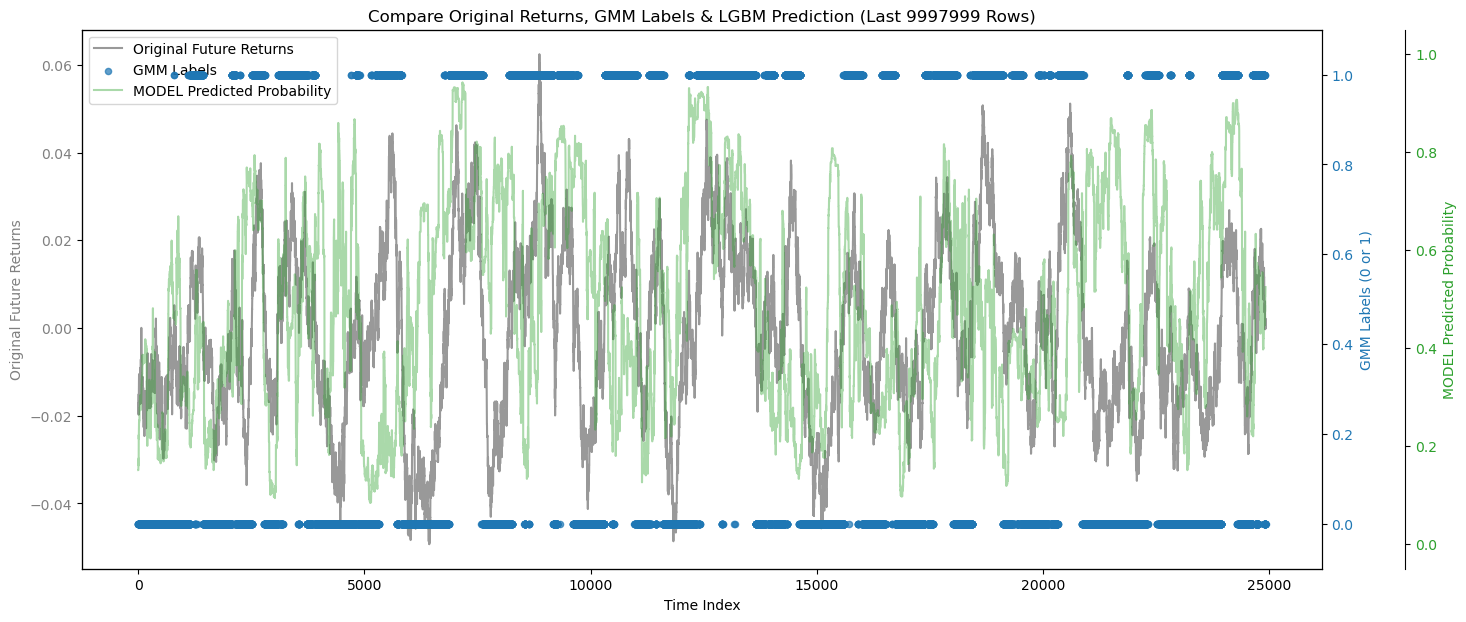

In [58]:
plot_last_n_rows(y_test, y_test_binary, y_pred_prob, n=9997999)

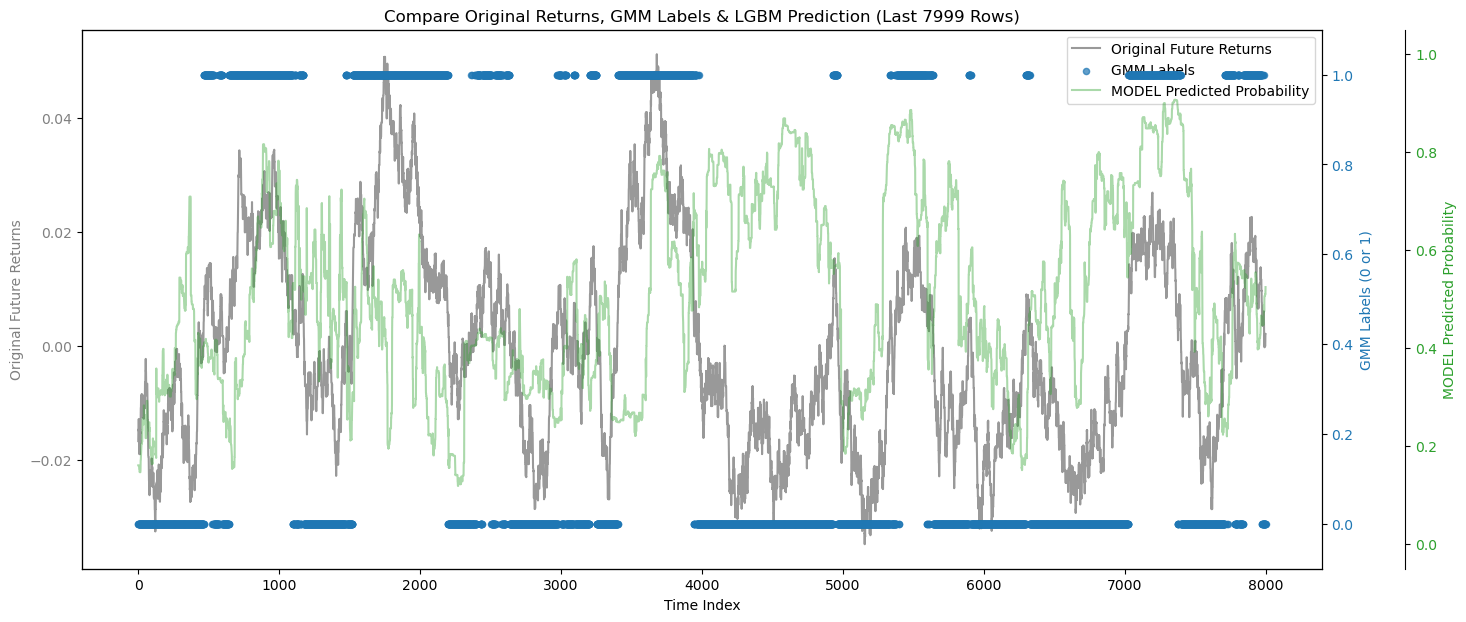

In [20]:
plot_last_n_rows(y_test, y_test_binary, y_pred_prob, n=7999)

C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


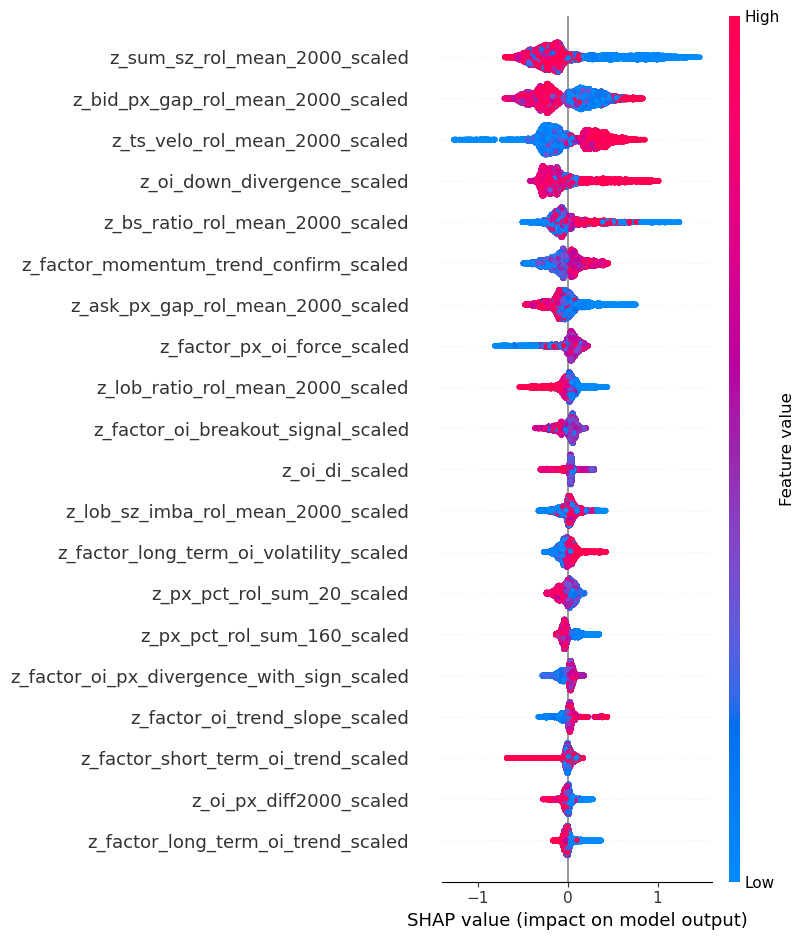

In [21]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train, plot_type="dot")  # 全体概览

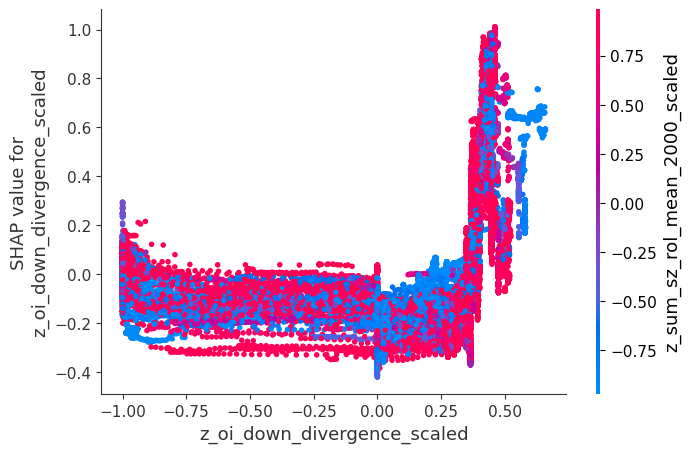

In [22]:
shap.dependence_plot("z_oi_down_divergence_scaled", shap_values, X_train)  # 局部分析


In [81]:
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

cat_model = CatBoostClassifier(iterations=4000, learning_rate=0.005, depth=7, verbose=0)
cat_model.fit(X_train, y_train_binary)

# 预测
y_pred_prob = cat_model.predict_proba(X_test)[:, 1]
y_pred_label = (y_pred_prob >= 0.5).astype(int)

# 评估
print("CatBoost Test Accuracy:", accuracy_score(y_test_binary, y_pred_label))
print(classification_report(y_test_binary, y_pred_label))
cm = confusion_matrix(y_test_binary, y_pred_label)
print("Confusion Matrix:")
print(cm)

CatBoost Test Accuracy: 0.5456916964321548
              precision    recall  f1-score   support

           0       0.62      0.59      0.60     14598
           1       0.45      0.49      0.47     10319

    accuracy                           0.55     24917
   macro avg       0.54      0.54      0.54     24917
weighted avg       0.55      0.55      0.55     24917

Confusion Matrix:
[[8573 6025]
 [5295 5024]]


In [82]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

# 设置上下概率阈值
lower_thresh = 0.1
upper_thresh = 0.9

# 初始化标签为 -1（表示不出手）
y_pred_label = np.full_like(y_pred_prob, fill_value=-1, dtype=int)

# 预测为下跌（做空）
y_pred_label[y_pred_prob <= lower_thresh] = 0

# 预测为上涨（做多）
y_pred_label[y_pred_prob >= upper_thresh] = 1

# 筛选出模型明确给出方向的样本
mask = y_pred_label != -1

# 评估：只看模型明确判断的那部分（即“出手”的预测）
print("✅ CatBoost Test Accuracy (Confident Predictions):", accuracy_score(y_test_binary[mask], y_pred_label[mask]))
print("📊 Classification Report (Confident Predictions):")
print(classification_report(y_test_binary[mask], y_pred_label[mask]))

print("🧮 Confusion Matrix (Confident Predictions):")
print(confusion_matrix(y_test_binary[mask], y_pred_label[mask]))

# 出手率（模型愿意下单的比例）
print("📈 Trading Rate (Confident Predictions):", mask.mean())


✅ CatBoost Test Accuracy (Confident Predictions): 0.7101833443781754
📊 Classification Report (Confident Predictions):
              precision    recall  f1-score   support

           0       0.71      0.71      0.71      2245
           1       0.71      0.71      0.71      2282

    accuracy                           0.71      4527
   macro avg       0.71      0.71      0.71      4527
weighted avg       0.71      0.71      0.71      4527

🧮 Confusion Matrix (Confident Predictions):
[[1602  643]
 [ 669 1613]]
📈 Trading Rate (Confident Predictions): 0.18168318818477344


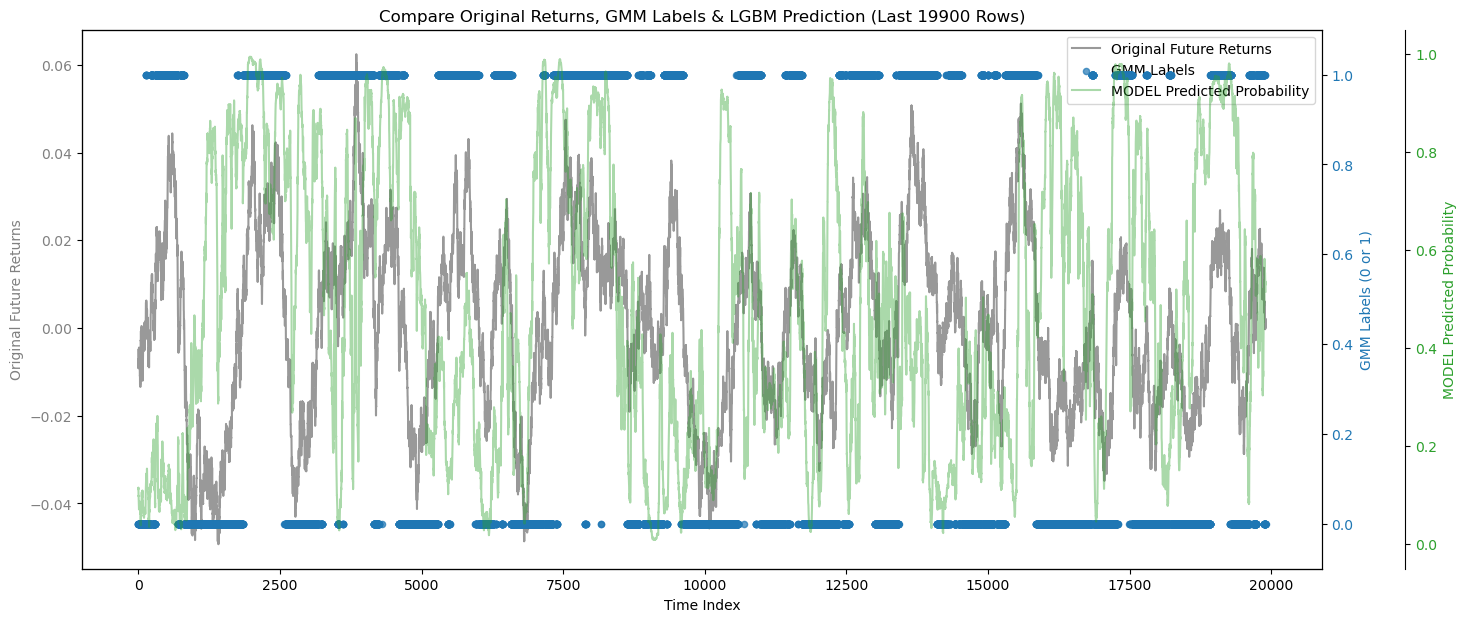

In [25]:
plot_last_n_rows(y_test, y_test_binary, y_pred_prob, n=19900)


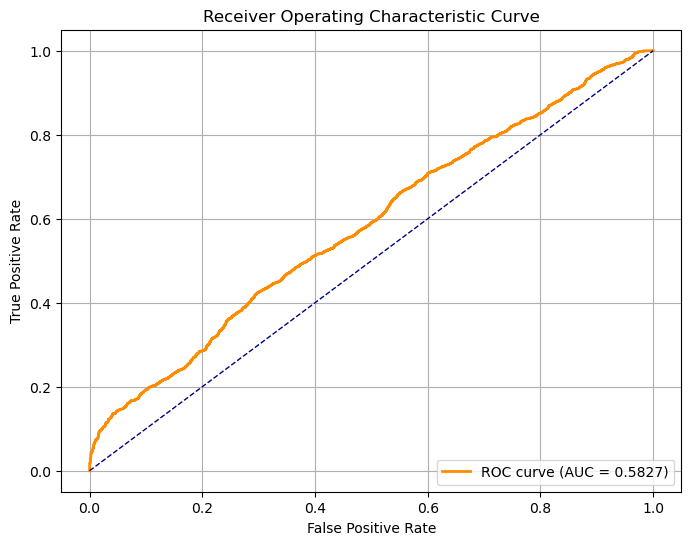

C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


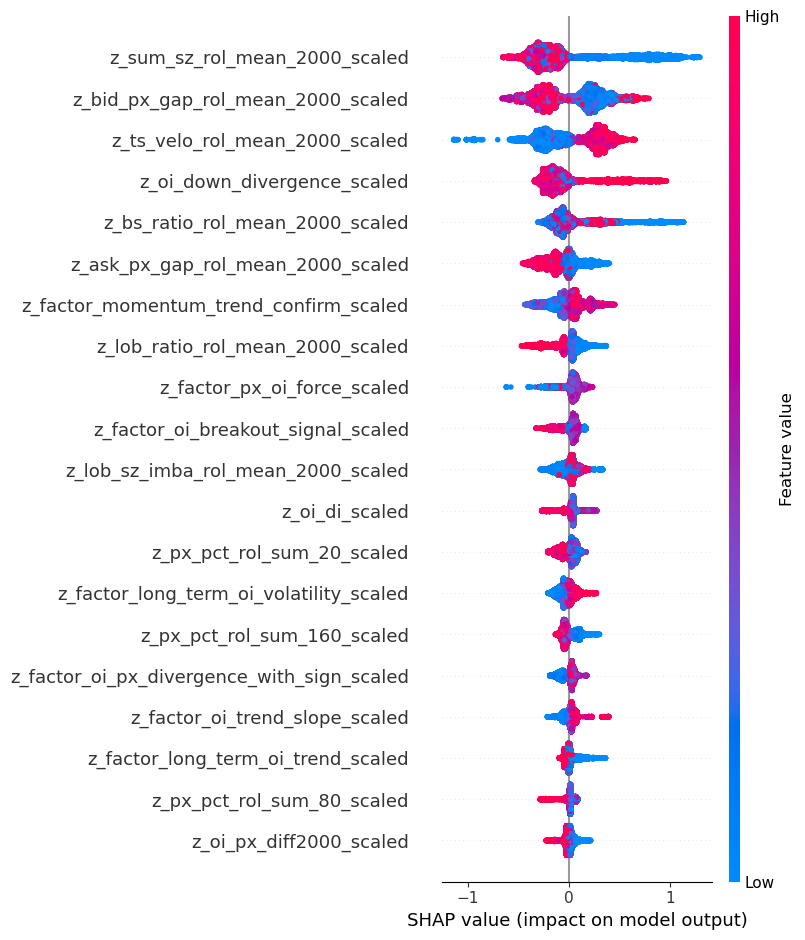

In [27]:
import matplotlib.pyplot as plt
import shap
from sklearn.metrics import roc_curve, auc, RocCurveDisplay

# 1. ROC 曲线（推荐自定义绘图）
y_score = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test_binary, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# 如果你想也画一下 sklearn 内置版本
# RocCurveDisplay.from_estimator(model, X_test, y_test)  # 可选

# 2. SHAP 值解释
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)


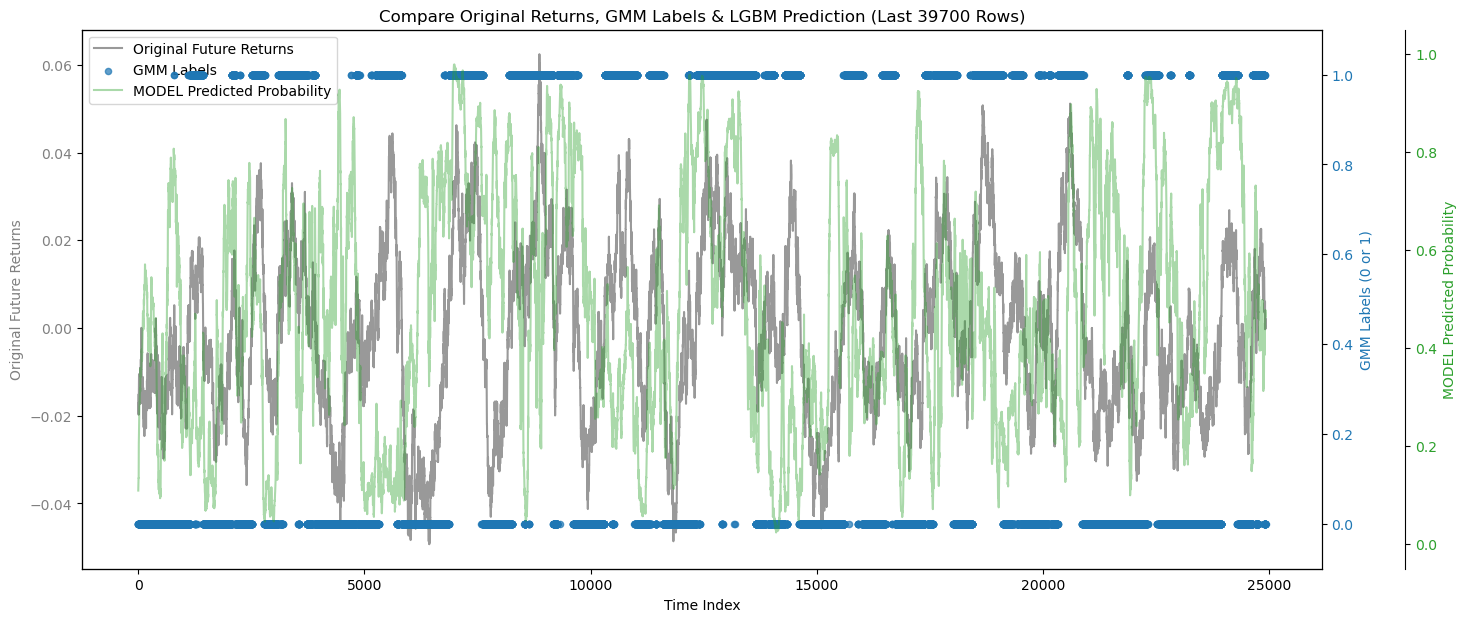

In [28]:
plot_last_n_rows(y_test, y_test_binary, y_pred_prob, n=39700)


In [30]:
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

xgb_model = xgb.XGBClassifier(n_estimators=5000, learning_rate=0.005, max_depth=7, verbosity=0, use_label_encoder=False)
xgb_model.fit(X_train, y_train_binary)

# 预测
y_pred_prob = xgb_model.predict_proba(X_test)[:, 1]
y_pred_label = (y_pred_prob >= 0.5).astype(int)

# 评估
print("XGBoost Test Accuracy:", accuracy_score(y_test_binary, y_pred_label))
print(classification_report(y_test_binary, y_pred_label))
m = confusion_matrix(y_test_binary, y_pred_label)
print("Confusion Matrix:")
print(cm)

XGBoost Test Accuracy: 0.5624272584982141
              precision    recall  f1-score   support

           0       0.64      0.57      0.60     14598
           1       0.48      0.55      0.51     10319

    accuracy                           0.56     24917
   macro avg       0.56      0.56      0.56     24917
weighted avg       0.57      0.56      0.57     24917

Confusion Matrix:
[[8706 5892]
 [5291 5028]]


In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

# 设置上下概率阈值
lower_thresh = 0.1
upper_thresh = 0.9

# 初始化标签为 -1（表示不出手）
y_pred_label = np.full_like(y_pred_prob, fill_value=-1, dtype=int)

# 预测为下跌（做空）
y_pred_label[y_pred_prob <= lower_thresh] = 0

# 预测为上涨（做多）
y_pred_label[y_pred_prob >= upper_thresh] = 1

# 筛选出模型明确给出方向的样本
mask = y_pred_label != -1

# 评估：只看模型明确判断的那部分（即“出手”的预测）
print("✅ CatBoost Test Accuracy (Confident Predictions):", accuracy_score(y_test_binary[mask], y_pred_label[mask]))
print("📊 Classification Report (Confident Predictions):")
print(classification_report(y_test_binary[mask], y_pred_label[mask]))

print("🧮 Confusion Matrix (Confident Predictions):")
print(confusion_matrix(y_test_binary[mask], y_pred_label[mask]))

# 出手率（模型愿意下单的比例）
print("📈 Trading Rate (Confident Predictions):", mask.mean())


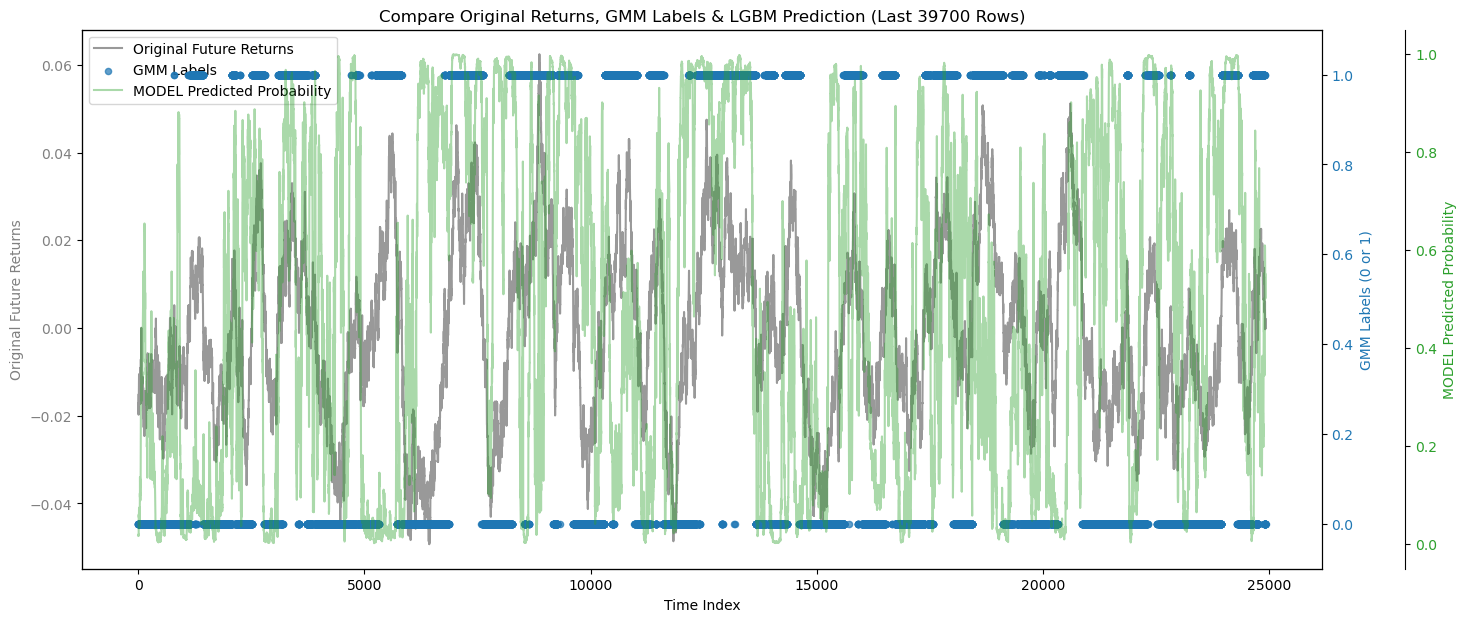

In [31]:
plot_last_n_rows(y_test, y_test_binary, y_pred_prob, n=39700)


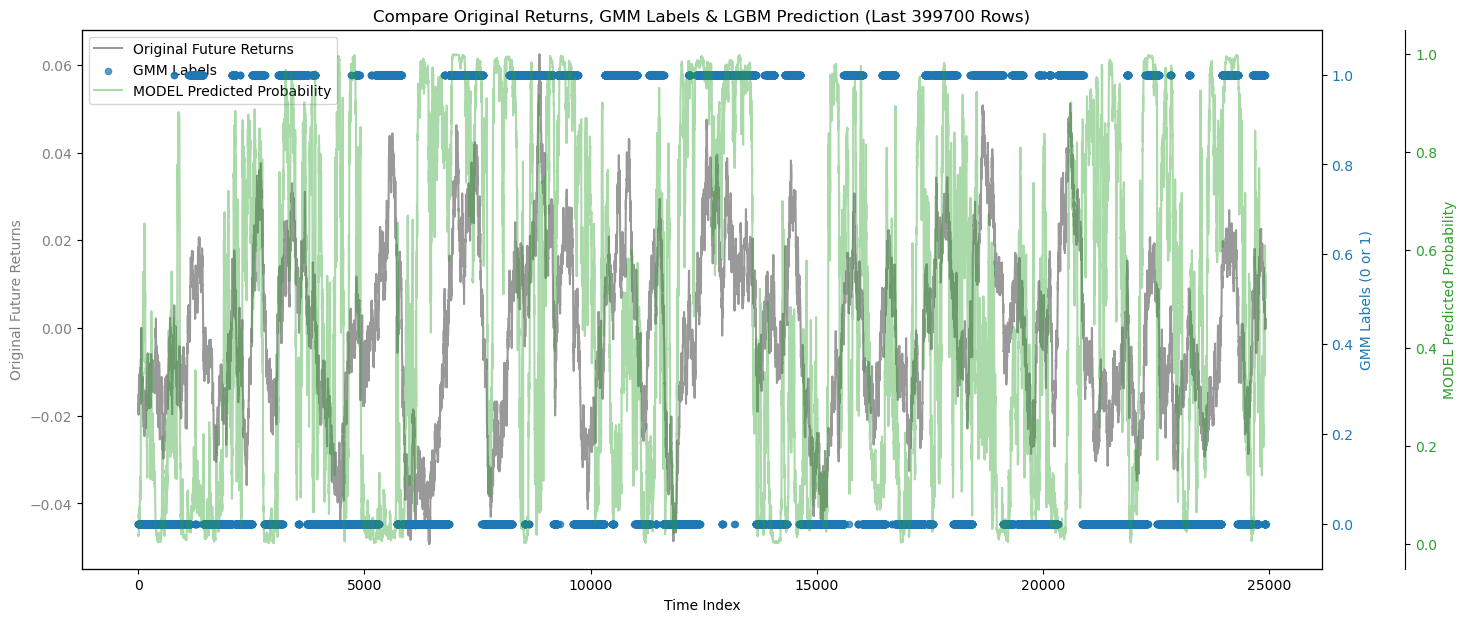

In [32]:
plot_last_n_rows(y_test, y_test_binary, y_pred_prob, n=399700)


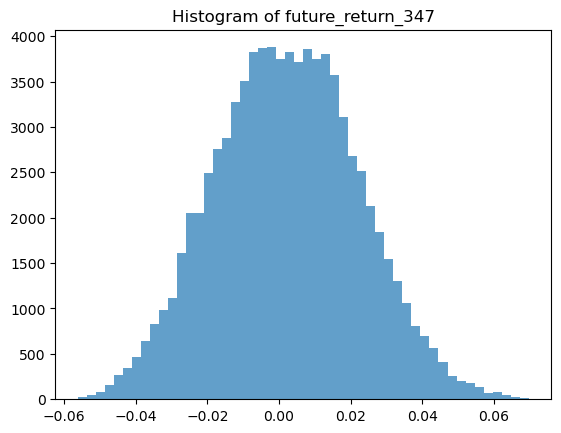

Skewness: 0.0698, Kurtosis: -0.2698
Shapiro-Wilk Test: stat=0.9934, p-value=0.0000
拒绝正态分布假设，数据可能不是正态分布


In [33]:
import polars as pl
import matplotlib.pyplot as plt
from scipy.stats import shapiro

# 读数据


# 1. 画直方图（先导出为numpy）
plt.hist(mo_df[target_col].to_numpy(), bins=50, alpha=0.7)
plt.title(f"Histogram of {target_col}")
plt.show()

# 2. 计算偏度和峰度
skewness = mo_df.select(pl.col(target_col).skew()).item()
kurtosis = mo_df.select(pl.col(target_col).kurtosis()).item()
print(f"Skewness: {skewness:.4f}, Kurtosis: {kurtosis:.4f}")

# 3. Shapiro-Wilk 检验 (样本不要太大，建议 <5000)
sample = mo_df[target_col].to_numpy()[:5000]
stat, p_value = shapiro(sample)
print(f"Shapiro-Wilk Test: stat={stat:.4f}, p-value={p_value:.4f}")

if p_value > 0.05:
    print("无法拒绝正态分布假设，数据可能近似正态分布")
else:
    print("拒绝正态分布假设，数据可能不是正态分布")


In [34]:
def train_evaluate_lgb(X_train, y_train, X_test, y_test):
    model = lgb.LGBMClassifier(n_estimators=1000, learning_rate=0.05, max_depth=7, verbose=-1)
    model.fit(X_train, y_train)
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    y_pred_label = (y_pred_prob >= 0.5).astype(int)
    print("LightGBM Test Accuracy:", accuracy_score(y_test, y_pred_label))
    print(classification_report(y_test, y_pred_label))
    return y_pred_prob

def train_evaluate_xgb(X_train, y_train, X_test, y_test):
    model = xgb.XGBClassifier(n_estimators=1000, learning_rate=0.05, max_depth=7, eval_metric='logloss')
    model.fit(X_train, y_train)
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    y_pred_label = (y_pred_prob >= 0.5).astype(int)
    print("XGBoost Test Accuracy:", accuracy_score(y_test, y_pred_label))
    print(classification_report(y_test, y_pred_label))
    return y_pred_prob

def train_evaluate_catboost(X_train, y_train, X_test, y_test):
    model = CatBoostClassifier(iterations=1000, learning_rate=0.05, depth=7, verbose=False)
    model.fit(X_train, y_train)
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    y_pred_label = (y_pred_prob >= 0.5).astype(int)
    print("CatBoost Test Accuracy:", accuracy_score(y_test, y_pred_label))
    print(classification_report(y_test, y_pred_label))
    return y_pred_prob


In [35]:
def plot_model_comparison(y_test, y_test_binary, preds_dict, n=700):
    """
    preds_dict: dict, key=模型名, value=对应的预测概率数组
    """
    y_test_slice = y_test[-n:]
    y_test_binary_slice = y_test_binary[-n:]
    time_index = np.arange(len(y_test_slice))

    fig, ax1 = plt.subplots(figsize=(16, 7))

    # 原始收益
    ax1.plot(time_index, y_test_slice, label="Original Future Returns", color='gray', alpha=0.8)
    ax1.set_ylabel("Original Future Returns", color='gray')
    ax1.tick_params(axis='y', labelcolor='gray')

    # GMM标签
    ax2 = ax1.twinx()
    ax2.scatter(time_index, y_test_binary_slice, label="GMM Labels", color='tab:blue', marker='o', s=20, alpha=0.7)
    ax2.set_ylabel("GMM Labels (0 or 1)", color='tab:blue')
    ax2.tick_params(axis='y', labelcolor='tab:blue')
    ax2.set_ylim(-0.1, 1.1)

    # 多模型预测概率，右侧y轴，颜色自动分配
    ax3 = ax1.twinx()
    ax3.spines.right.set_position(("outward", 60))
    colors = ['tab:green', 'tab:red', 'tab:orange', 'tab:purple']
    
    for i, (model_name, pred_prob) in enumerate(preds_dict.items()):
        pred_prob_slice = pred_prob[-n:]
        ax3.plot(time_index, pred_prob_slice, label=f"{model_name} Predicted Probability", color=colors[i % len(colors)], alpha=0.1)
    
    ax3.set_ylabel("Predicted Probability", color='black')
    ax3.tick_params(axis='y', labelcolor='black')
    ax3.set_ylim(-0.05, 1.05)

    ax1.set_xlabel("Time Index")
    plt.title(f"Compare Original Returns, GMM Labels & Model Predictions (Last {n} Rows)")

    # 合并图例
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    lines_3, labels_3 = ax3.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2 + lines_3, labels_1 + labels_2 + labels_3, loc='best')

    plt.show()


In [38]:
y_pred_prob_lgb = train_evaluate_lgb(X_train, y_train_binary, X_test, y_test_binary)
y_pred_prob_xgb = train_evaluate_xgb(X_train, y_train_binary, X_test, y_test_binary)
y_pred_prob_cat = train_evaluate_catboost(X_train, y_train_binary, X_test, y_test_binary)

preds_dict = {
    'LightGBM': y_pred_prob_lgb,
    'XGBoost': y_pred_prob_xgb,
    'CatBoost': y_pred_prob_cat,
}


LightGBM Test Accuracy: 0.5582132680499258
              precision    recall  f1-score   support

           0       0.63      0.58      0.61     14598
           1       0.47      0.53      0.50     10319

    accuracy                           0.56     24917
   macro avg       0.55      0.55      0.55     24917
weighted avg       0.57      0.56      0.56     24917

XGBoost Test Accuracy: 0.5564072721435165
              precision    recall  f1-score   support

           0       0.64      0.56      0.60     14598
           1       0.47      0.55      0.51     10319

    accuracy                           0.56     24917
   macro avg       0.55      0.56      0.55     24917
weighted avg       0.57      0.56      0.56     24917

CatBoost Test Accuracy: 0.55255448087651
              precision    recall  f1-score   support

           0       0.63      0.59      0.61     14598
           1       0.46      0.51      0.48     10319

    accuracy                           0.55     24917
  

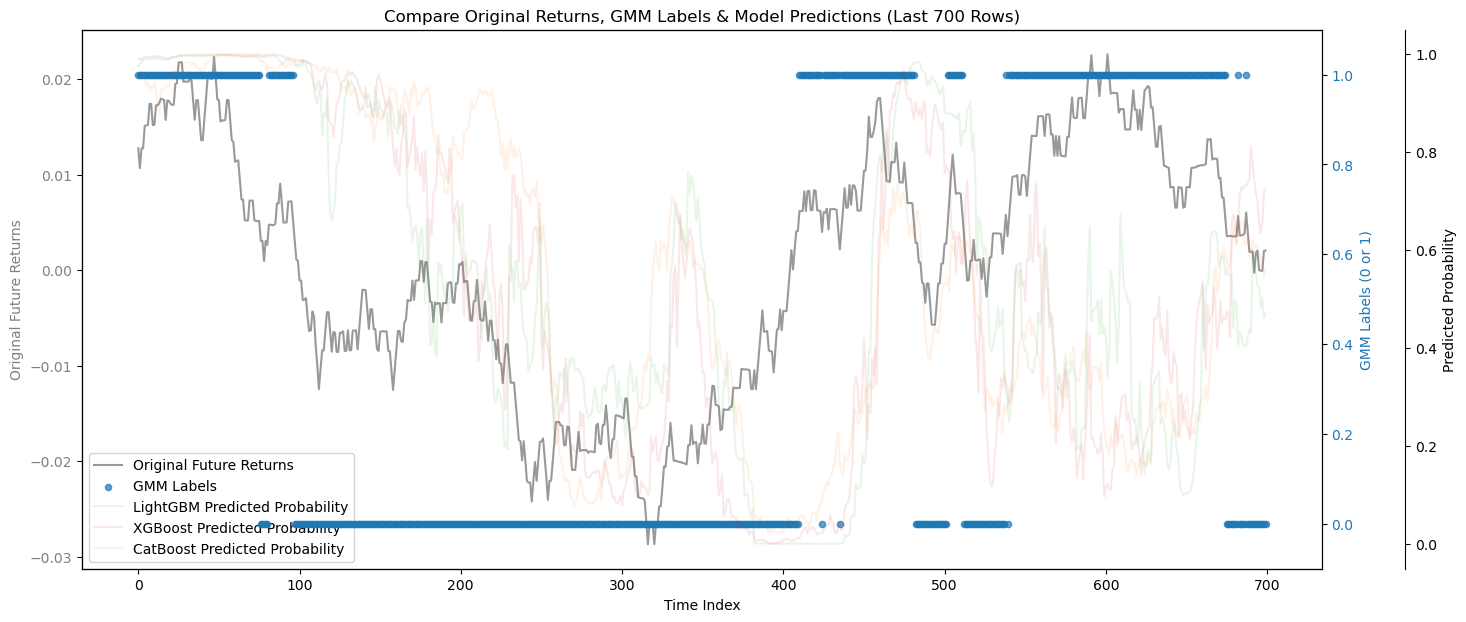

In [39]:
plot_model_comparison(y_test, y_test_binary, preds_dict, n=700)

In [89]:
import pandas as pd
from scipy.stats import spearmanr, pearsonr

# 创建 DataFrame，只保留模型出手的样本
df_result = pd.DataFrame({
    'true_return': y_test[mask],          # 真实收益
    'predicted': y_pred_label[mask],      # 预测标签（0 或 1）
    'pred_prob': y_pred_prob[mask]        # 概率（可选，用于排序或分组）
})

# 排序指标可以选用 pred_prob（推荐），而不是 0/1 的 predicted
df_result['rank'] = df_result['pred_prob'].rank(ascending=False)

# 分组看 top 10%、top 20% 的平均真实收益
top_10 = df_result[df_result['rank'] <= len(df_result) * 0.1]
top_20 = df_result[df_result['rank'] <= len(df_result) * 0.2]

print(f"Top 10% 平均真实收益: {top_10['true_return'].mean():.6f}")
print(f"Top 20% 平均真实收益: {top_20['true_return'].mean():.6f}")

# 信息系数（IC）：建议用 pred_prob 作为连续变量
ic = pearsonr(df_result['pred_prob'], df_result['true_return'])[0]
rank_ic = spearmanr(df_result['pred_prob'], df_result['true_return'])[0]

print(f"📉 Pearson IC: {ic:.4f}")
print(f"📉 Rank IC（秩相关）: {rank_ic:.4f}")
long_returns = df_result[df_result['predicted'] == 1]['true_return']
short_returns = -df_result[df_result['predicted'] == 0]['true_return']  # 做空收益是 -return

print(f"📈 多头平均收益: {long_returns.mean():.6f}")
print(f"📉 空头平均收益: {short_returns.mean():.6f}")
print(f"💰 多空平均收益: {(long_returns.mean() + short_returns.mean()):.6f}")
print("✅ 多头胜率:", (long_returns > 0).mean())
print("✅ 空头胜率:", (short_returns > 0).mean())


Top 10% 平均真实收益: 0.018949
Top 20% 平均真实收益: 0.014383
📉 Pearson IC: 0.3705
📉 Rank IC（秩相关）: 0.4351
📈 多头平均收益: 0.010039
📉 空头平均收益: 0.002741
💰 多空平均收益: 0.012779
✅ 多头胜率: 0.7584219858156028
✅ 空头胜率: 0.6230735358872743


In [40]:
import torch
print(torch.cuda.is_available())  # True 表示可以用GPU，False 表示没装GPU版本或没驱动
print(torch.__version__)

True
2.5.1


C:\Users\Grayman\AppData\Local\Temp\ipykernel_41228\3044644876.py:23: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


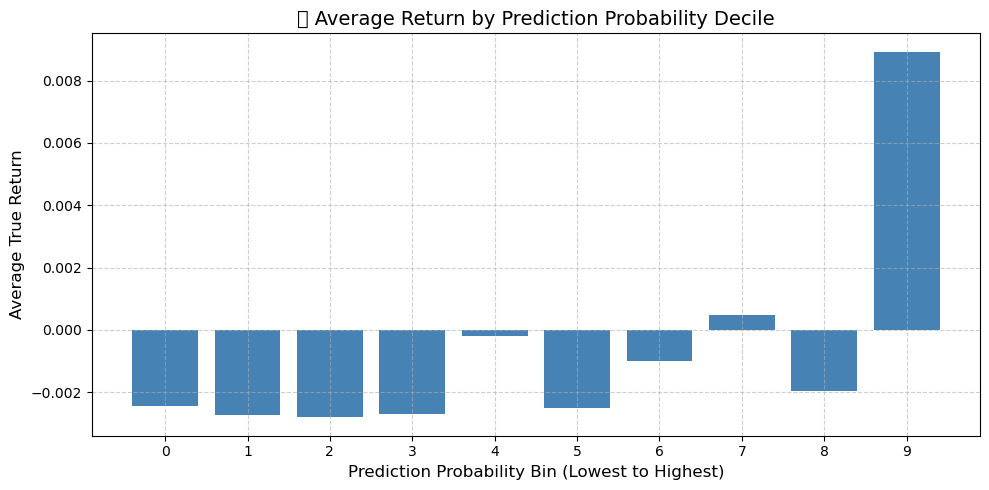

In [97]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df_result has columns: true_return, pred_prob
df_result['bin'] = pd.qcut(df_result['pred_prob'], q=10, labels=False)

# Group by bin and calculate statistics
bin_stats = df_result.groupby('bin').agg(
    mean_return=('true_return', 'mean'),
    std_return=('true_return', 'std'),
    win_rate=('true_return', lambda x: (x > 0).mean()),
    count=('true_return', 'count')
).reset_index()

# Plot average return by bin
plt.figure(figsize=(10, 5))
plt.bar(bin_stats['bin'], bin_stats['mean_return'], color='steelblue')
plt.title("📊 Average Return by Prediction Probability Decile", fontsize=14)
plt.xlabel("Prediction Probability Bin (Lowest to Highest)", fontsize=12)
plt.ylabel("Average True Return", fontsize=12)
plt.xticks(bin_stats['bin'])
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [99]:
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.preprocessing import LabelEncoder
import torch

# Label Encode y（如果是0/1就不用）
y_train_enc = y_train_binary.astype(int)
y_test_enc = y_test_binary.astype(int)

# TabNet 训练
tabnet = TabNetClassifier(
    device_name='cuda' if torch.cuda.is_available() else 'cpu',
    verbose=1
)
tabnet.fit(
    X_train=X_train.values, y_train=y_train_enc,
    eval_set=[(X_test.values, y_test_enc)],
    eval_metric=['accuracy'],
    max_epochs=200,
    patience=20,
    batch_size=1024,
    virtual_batch_size=128
)

# 预测概率
y_pred_prob_tabnet = tabnet.predict_proba(X_test.values)[:, 1]


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.6523  | val_0_accuracy: 0.52189 |  0:00:02s
epoch 1  | loss: 0.52726 | val_0_accuracy: 0.52715 |  0:00:05s
epoch 2  | loss: 0.4203  | val_0_accuracy: 0.5125  |  0:00:07s
epoch 3  | loss: 0.37158 | val_0_accuracy: 0.56082 |  0:00:09s
epoch 4  | loss: 0.33904 | val_0_accuracy: 0.51463 |  0:00:12s
epoch 5  | loss: 0.30507 | val_0_accuracy: 0.50331 |  0:00:14s
epoch 6  | loss: 0.30659 | val_0_accuracy: 0.52414 |  0:00:16s
epoch 7  | loss: 0.27858 | val_0_accuracy: 0.52165 |  0:00:19s
epoch 8  | loss: 0.25313 | val_0_accuracy: 0.53341 |  0:00:21s
epoch 9  | loss: 0.2398  | val_0_accuracy: 0.51531 |  0:00:23s
epoch 10 | loss: 0.23242 | val_0_accuracy: 0.50383 |  0:00:25s
epoch 11 | loss: 0.22542 | val_0_accuracy: 0.52165 |  0:00:28s
epoch 12 | loss: 0.21219 | val_0_accuracy: 0.51455 |  0:00:30s
epoch 13 | loss: 0.21821 | val_0_accuracy: 0.52257 |  0:00:32s
epoch 14 | loss: 0.21506 | val_0_accuracy: 0.52225 |  0:00:34s
epoch 15 | loss: 0.21635 | val_0_accuracy: 0.50841 |  0

C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [101]:
# 用于阈值分箱
y_pred_label = np.full_like(y_pred_prob_tabnet, fill_value=-1, dtype=int)
y_pred_label[y_pred_prob_tabnet <= 0.1] = 0
y_pred_label[y_pred_prob_tabnet >= 0.9] = 1
mask = y_pred_label != -1
print("TabNet Confident Accuracy:", accuracy_score(y_test_binary[mask], y_pred_label[mask]))


TabNet Confident Accuracy: 0.6224039460020768


y_test_binary length: 24917
y_pred_prob_tabnet length: 24917
mask length: 24917
y_true_confident length: 7704
y_pred_confident length: 7704


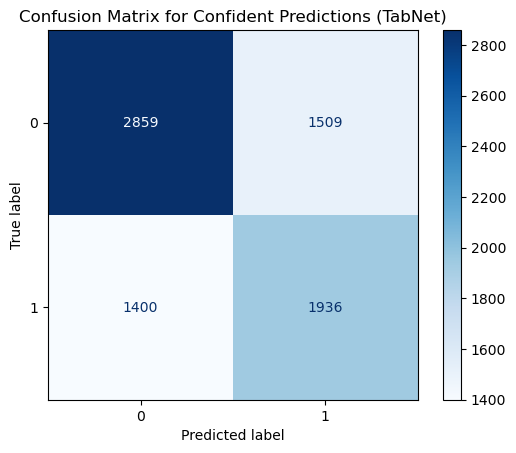

In [208]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

print(f"y_test_binary length: {len(y_test_binary)}")
print(f"y_pred_prob_tabnet length: {len(y_pred_prob_tabnet)}")

# 生成分箱标签
y_pred_label = np.full_like(y_pred_prob_tabnet, fill_value=-1, dtype=int)
y_pred_label[y_pred_prob_tabnet <= 0.1] = 0
y_pred_label[y_pred_prob_tabnet >= 0.9] = 1
mask = y_pred_label != -1

print(f"mask length: {len(mask)}")  # 应该和 y_pred_label 一致

# 使用mask筛选后，长度应该相同
y_true_confident = y_test_binary[mask]
y_pred_confident = y_pred_label[mask]

print(f"y_true_confident length: {len(y_true_confident)}")
print(f"y_pred_confident length: {len(y_pred_confident)}")

# 计算混淆矩阵并绘图
cm = confusion_matrix(y_true_confident, y_pred_confident)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Confident Predictions (TabNet)")
plt.show()


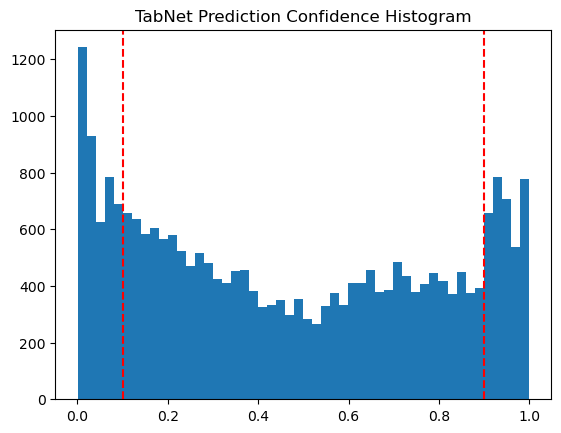

In [105]:
import matplotlib.pyplot as plt

plt.hist(y_pred_prob_tabnet, bins=50)
plt.axvline(0.1, color='red', linestyle='--')
plt.axvline(0.9, color='red', linestyle='--')
plt.title("TabNet Prediction Confidence Histogram")
plt.show()


In [190]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# 模拟数据
# X_train: (N_samples, N_features)
# y_train_binary: (N_samples,)
# X_test, y_test_binary 同理

def create_sequences(X, y, time_steps=100):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:i+time_steps])
        ys.append(y[i+time_steps])  # 标签对应下一个时间步
    return np.array(Xs), np.array(ys)


# 先创建时间序列数据
X_train_seq, y_train_seq = create_sequences(X_train, y_train_binary, time_steps=200)
X_test_seq, y_test_seq = create_sequences(X_test, y_test_binary, time_steps=200)

# 转成TensorDataset
train_dataset = TensorDataset(torch.tensor(X_train_seq, dtype=torch.float32),
                              torch.tensor(y_train_seq, dtype=torch.float32))
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# 定义模型
class GRUClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1, num_layers=2, bidirectional=False):
        super().__init__()
        self.bidirectional = bidirectional
        self.gru = nn.GRU(
            input_dim, hidden_dim, num_layers,
            batch_first=True, dropout=0.3,
            bidirectional=bidirectional
        )
        factor = 2 if bidirectional else 1
        self.layer_norm = nn.LayerNorm(hidden_dim * factor)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_dim * factor, output_dim)

    def forward(self, x):
        out, _ = self.gru(x)  # out shape: (B, T, H)
        out = out[:, -1, :]   # 取最后时间步，shape: (B, H*factor)
        out = self.layer_norm(out)
        out = self.dropout(out)
        out = torch.sigmoid(self.fc(out)).squeeze()
        return out



model = GRUClassifier(input_dim=X_train_seq.shape[2], hidden_dim=64).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# 训练
model.train()
for epoch in range(50):
    epoch_loss = 0
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        y_pred = model(x_batch)
        loss = criterion(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * x_batch.size(0)
    epoch_loss /= len(train_dataset)
    print(f"Epoch {epoch}, Loss: {epoch_loss:.4f}")

# 测试预测
model.eval()
with torch.no_grad():
    X_test_tensor = torch.tensor(X_test_seq, dtype=torch.float32).to(device)
    y_pred_prob = model(X_test_tensor).cpu().numpy()



Using device: cuda
Epoch 0, Loss: 0.4462
Epoch 1, Loss: 0.2091
Epoch 2, Loss: 0.1690
Epoch 3, Loss: 0.1507
Epoch 4, Loss: 0.1429
Epoch 5, Loss: 0.1360
Epoch 6, Loss: 0.1291
Epoch 7, Loss: 0.1232
Epoch 8, Loss: 0.1197
Epoch 9, Loss: 0.1144
Epoch 10, Loss: 0.1125
Epoch 11, Loss: 0.1083
Epoch 12, Loss: 0.1057
Epoch 13, Loss: 0.1048
Epoch 14, Loss: 0.1011
Epoch 15, Loss: 0.1009
Epoch 16, Loss: 0.1009
Epoch 17, Loss: 0.1122
Epoch 18, Loss: 0.0962
Epoch 19, Loss: 0.0939
Epoch 20, Loss: 0.0958
Epoch 21, Loss: 0.0925
Epoch 22, Loss: 0.0925
Epoch 23, Loss: 0.0927
Epoch 24, Loss: 0.0904
Epoch 25, Loss: 0.0915
Epoch 26, Loss: 0.0881
Epoch 27, Loss: 0.0892
Epoch 28, Loss: 0.0863
Epoch 29, Loss: 0.0875
Epoch 30, Loss: 0.0883
Epoch 31, Loss: 0.0854
Epoch 32, Loss: 0.0845
Epoch 33, Loss: 0.0837
Epoch 34, Loss: 0.0833
Epoch 35, Loss: 0.0819
Epoch 36, Loss: 0.0825
Epoch 37, Loss: 0.0811
Epoch 38, Loss: 0.0821
Epoch 39, Loss: 0.0836
Epoch 40, Loss: 0.0806
Epoch 41, Loss: 0.0852
Epoch 42, Loss: 0.0805
Ep

In [192]:
# 普通评估（概率）
print("=== Evaluation on test set ===")
print(f"Predicted probabilities (first 10): {y_pred_prob[:10]}")

# 阈值分类预测，阈值默认0.5
y_pred_label = (y_pred_prob >= 0.5).astype(int)

print(f"Accuracy: {accuracy_score(y_test_seq, y_pred_label):.4f}")
print("Classification Report:")
print(classification_report(y_test_seq, y_pred_label))



=== Evaluation on test set ===
Predicted probabilities (first 10): [0.9991948  0.9991997  0.9992048  0.9992099  0.9992149  0.9992198
 0.99922454 0.99922895 0.99923325 0.9992372 ]
Accuracy: 0.5061
Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.47      0.53     14398
           1       0.43      0.56      0.48     10319

    accuracy                           0.51     24717
   macro avg       0.51      0.51      0.51     24717
weighted avg       0.53      0.51      0.51     24717



In [194]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 假设 y_pred_prob_gru 是GRU模型预测的概率，y_test_seq是测试集真实标签
print("X_test_seq shape:", X_test_seq.shape)
print("y_test_seq shape:", y_test_seq.shape)
print("y_pred_prob shape:", y_pred_prob.shape)

lower_thresh = 0.1
upper_thresh = 0.9

y_pred_label = np.full_like(y_pred_prob, -1, dtype=int)
y_pred_label[y_pred_prob <= lower_thresh] = 0
y_pred_label[y_pred_prob >= upper_thresh] = 1
mask = y_pred_label != -1

print("Accuracy:", accuracy_score(y_test_seq[mask], y_pred_label[mask]))
print(classification_report(y_test_seq[mask], y_pred_label[mask]))
print(confusion_matrix(y_test_seq[mask], y_pred_label[mask]))
print("Trading Rate:", mask.mean())



X_test_seq shape: (24717, 200, 36)
y_test_seq shape: (24717,)
y_pred_prob shape: (24717,)
Accuracy: 0.5137303944557344
              precision    recall  f1-score   support

           0       0.60      0.47      0.53     11136
           1       0.44      0.57      0.50      8055

    accuracy                           0.51     19191
   macro avg       0.52      0.52      0.51     19191
weighted avg       0.53      0.51      0.52     19191

[[5257 5879]
 [3453 4602]]
Trading Rate: 0.7764291782983371


In [196]:
import matplotlib.pyplot as plt
import numpy as np

def plot_gru_predictions(y_test_continuous, y_test_seq, y_pred_prob, y_pred_label, n=700,
                         lower_thresh=0.1, upper_thresh=0.9):
    """
    y_test_continuous: 原始连续收益或其他连续变量，长度和y_test_seq一致
    y_test_seq: 真实二分类标签（0或1）
    y_pred_prob: 模型预测概率（0~1之间）
    y_pred_label: 基于阈值生成的预测标签，可能含-1表示不出手
    n: 最后n个时间点
    """
    # 取最后 n 行数据切片
    y_test_cont_slice = y_test_continuous[-n:]
    y_test_seq_slice = y_test_seq[-n:]
    y_pred_prob_slice = y_pred_prob[-n:]
    y_pred_label_slice = y_pred_label[-n:]
    
    time_index = np.arange(len(y_test_seq_slice))  # 0 到 n-1
    
    fig, ax1 = plt.subplots(figsize=(16, 7))

    # 左侧y轴：原始连续收益曲线
    ax1.plot(time_index, y_test_cont_slice, label="Original Continuous Returns", color='gray', alpha=0.8)
    ax1.set_ylabel("Original Continuous Returns", color='gray')
    ax1.tick_params(axis='y', labelcolor='gray')

    # 右侧第1个y轴：真实二分类标签，散点图
    ax2 = ax1.twinx()
    ax2.scatter(time_index, y_test_seq_slice, label="True Labels", color='tab:blue', marker='o', s=20, alpha=0.7)
    ax2.set_ylabel("True Labels (0 or 1)", color='tab:blue')
    ax2.tick_params(axis='y', labelcolor='tab:blue')
    ax2.set_ylim(-0.1, 1.1)

    # 右侧第2个y轴，右偏移：预测概率曲线
    ax3 = ax1.twinx()
    ax3.spines.right.set_position(("outward", 60))
    ax3.plot(time_index, y_pred_prob_slice, label="Predicted Probability", color='tab:green', alpha=0.5)
    ax3.set_ylabel("Predicted Probability", color='tab:green')
    ax3.tick_params(axis='y', labelcolor='tab:green')
    ax3.set_ylim(-0.05, 1.05)

    # 标出阈值上下界，方便观察
    ax3.axhline(y=lower_thresh, color='red', linestyle='--', alpha=0.6, label=f"Lower Threshold = {lower_thresh}")
    ax3.axhline(y=upper_thresh, color='red', linestyle='--', alpha=0.6, label=f"Upper Threshold = {upper_thresh}")

    # 右侧第3个y轴，右偏移更多：预测标签（0/1/-1）散点图，-1用灰色标注为“不出手”
    ax4 = ax1.twinx()
    ax4.spines.right.set_position(("outward", 120))
    # 标记不同的预测标签
    colors = {1: 'green', 0: 'red', -1: 'gray'}
    markers = {1: 'o', 0: 'x', -1: '.'}
    for label_val in np.unique(y_pred_label_slice):
        mask = (y_pred_label_slice == label_val)
        ax4.scatter(time_index[mask], y_pred_label_slice[mask], 
                    label=f"Predicted Label = {label_val}", 
                    color=colors[label_val], marker=markers[label_val], s=30, alpha=0.6)
    ax4.set_ylabel("Predicted Label (-1=No Trade)", color='purple')
    ax4.tick_params(axis='y', labelcolor='purple')
    ax4.set_ylim(-1.1, 1.1)

    # x轴和标题
    ax1.set_xlabel("Time Index")
    plt.title(f"GRU Prediction vs True Labels & Original Returns (Last {n} points)")

    # 合并图例
    lines = []
    labels = []
    for ax in [ax1, ax2, ax3, ax4]:
        line, label = ax.get_legend_handles_labels()
        lines.extend(line)
        labels.extend(label)
    ax1.legend(lines, labels, loc='upper left')

    plt.show()


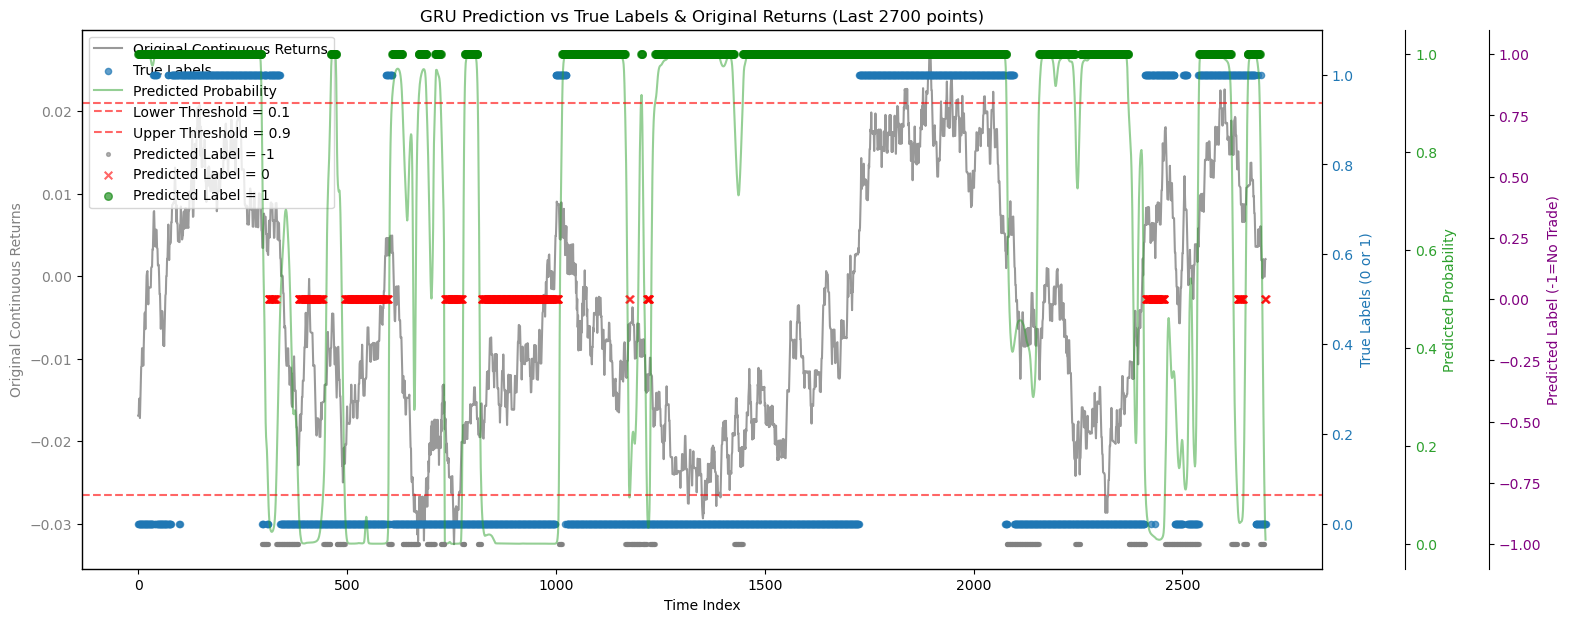

In [198]:
# 如果你有原始测试集连续收益，比如 price_test 或 returns_test
# y_test_continuous = returns_test[-len(y_test_seq):]

# 如果没有，可以用 y_test_seq 本身代替试试
y_test_continuous = y_test_seq.astype(float)

# 确保 y_pred_label 是你按阈值处理后的标签
# y_pred_label = your_thresholding_function(y_pred_prob, lower=0.1, upper=0.9)

plot_gru_predictions(
    y_test_continuous=y_test,
    y_test_seq=y_test_seq,
    y_pred_prob=y_pred_prob,
    y_pred_label=y_pred_label,
    n=2700,
    lower_thresh=0.1,
    upper_thresh=0.9,
)
